In [ ]:
!pip install botorch
!pip install brian2

  Using cached botorch-0.10.0-py3-none-any.whl.metadata (11 kB)
Using cached botorch-0.10.0-py3-none-any.whl (613 kB)


# Import

In [1]:
# add path to the current directory
%load_ext autoreload
%autoreload 2

import sys
import os
sys.path.append(os.getcwd())

# switch to the simulation directory
# Verify the current directory
print("Current directory:", os.getcwd())

%load_ext autoreload
%autoreload 2

import sys
# assert('neuron' not in sys.modules)
import os
nrn_options = "-nogui -NSTACK 100000 -NFRAME 20000"
os.environ["NEURON_MODULE_OPTIONS"] = nrn_options
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import matplotlib.animation as animation
import time
import math

import numpy as np
np.random.seed(237)
import matplotlib.pyplot as plt
from skopt.plots import plot_gaussian_process
from functools import partial
from skopt.plots import plot_convergence
from skopt import gp_minimize
from skopt.space import Real
import torch


from brian2 import *
from utils.brian2_utils import set_params_utils, eqs_utils, plotting_utils, obj_func_utils
from utils.botorch_utils import ibnn_utils

Current directory: /Users/dusiyi/Downloads/Pulkit_class/final_project/selective_stimulation
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


INFO       Cache size for target 'cython': 2380 MB.
You can call clear_cache('cython') to delete all files from the cache or manually delete files in the '/Users/dusiyi/Library/Caches/cython/brian_extensions' directory. [brian2]
WARNING    /opt/miniconda3/envs/brian2_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
 [py.warnings]


# Set up model

## params

In [2]:
# populations
N = 700
N_E = int(N * 0.8)  # pyramidal neurons
N_I = int(N * 0.2)  # interneurons
f = 0.1
p = 3
C_ext = 800
DC_amp = 0

# external stimuli
# rate = 3 * Hz # in external noise
currents_to_track = ['I_syn', 'I_AMPA_ext', 'I_GABA_rec', 'I_AMPA_rec', 'I_NMDA_rec', 'I_DC1', 'I_DC2', 'I_sino1', 'I_sino2']
currents_to_plot = currents_to_track

## currents

In [3]:
DC_input_ts = 1 * ms
sino_input_ts = 0.1 * ms

# currently set the duration of all currents to 0, so that they are not applied

DC_start_time1 = 0  # in ms
# DC_duration1 = 1000  # in ms
DC_duration1 = 0  # in ms
DC_amp1 = 0.1  # in nA
DC_amp_slope1 = 0.001  # in nA/ms

DC_start_time2 = 500  # in ms
# DC_duration2 = 2000  # in ms
DC_duration2 = 0  # in ms
DC_amp2 = -0.05  # in nA
DC_amp_slope2 = -0.001  # in nA/ms

sino_start_time1 = 0  # in ms
# sino_duration1=3000  # in ms
sino_duration1=0  # in ms
sino_amp1=0.5  # in nA
sino_freq1=30  # in Hz

sino_start_time2 = 1000  # in ms
# sino_duration2=2000  # in ms
sino_duration2=0  # in ms
sino_amp2=0.2  # in nA
sino_freq2=50  # in Hz



DC_input1 = set_params_utils.set_DC_input(DC_amp=DC_amp1, # in nA
                DC_amp_slope=DC_amp_slope1, # in nA/ms
                DC_duration=DC_duration1, # in ms
                DC_start_time=DC_start_time1, # in ms
                timestep=DC_input_ts
                )

DC_input2 = set_params_utils.set_DC_input(DC_amp=DC_amp2, # in nA
                DC_amp_slope=DC_amp_slope2, # in nA/ms
                DC_duration=DC_duration2, # in ms
                DC_start_time=DC_start_time2, # in ms
                timestep=DC_input_ts
                )

sino_input1 = set_params_utils.set_sino_input(sino_start_time=sino_start_time1, # in ms
                    sino_duration=sino_duration1, # in ms
                    sino_amp=sino_amp1, # in nA
                    sino_freq=sino_freq1, # in Hz
                    timestep=sino_input_ts
                    )

sino_input2 = set_params_utils.set_sino_input(sino_start_time=sino_start_time2, # in ms
                    sino_duration=sino_duration2, # in ms
                    sino_amp=sino_amp2, # in nA
                    sino_freq=sino_freq2, # in Hz
                    timestep=sino_input_ts
                    )

## run initial simulation

Starting simulation at t=0. s for a duration of 3. s
2.9001 s (96%) simulated in 10s, estimated < 1s remaining.
3. s (100%) simulated in 10s


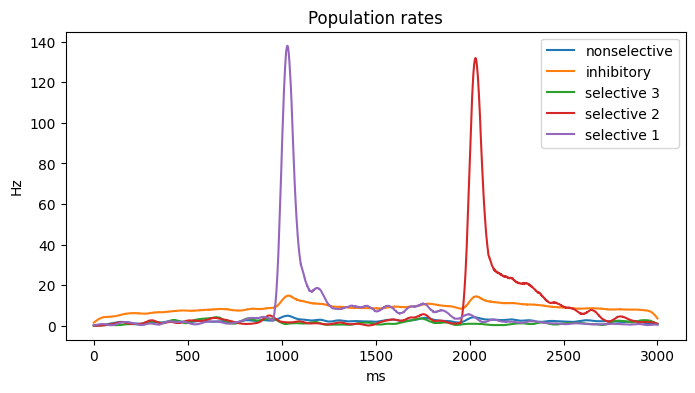

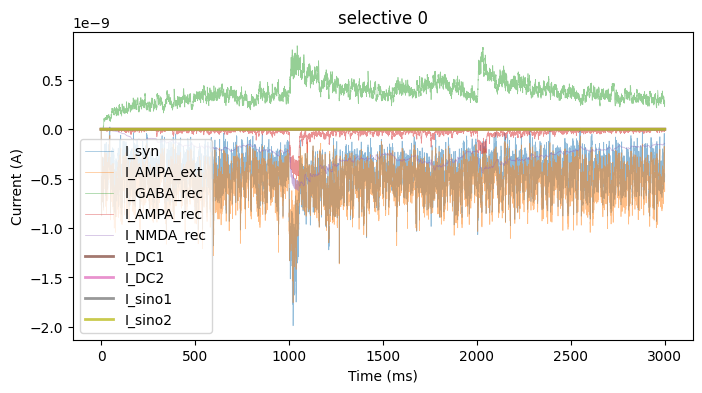

In [ ]:
start_scope()

N_sub = int(N_E * f)
N_non = int(N_E * (1. - f * p))


E_neuron_index = [0] # index of the neuron in the population
E_index_map = {0: 'nonselective'} # map the index in the monitor to population name
for i in range(p):
    E_neuron_index.append(N_non + i * N_sub)
    E_index_map[i+1] = f'selective {i}'


# voltage
V_L, V_thr, V_reset, V_E, V_I = set_params_utils.set_voltage()
# membrane capacitance and membrane leak
C_m_E, C_m_I, g_m_E, g_m_I = set_params_utils.set_membrane_params()

# AMPA (excitatory)
g_AMPA_ext_E, g_AMPA_rec_E, g_AMPA_ext_I, g_AMPA_rec_I, tau_AMPA = set_params_utils.set_AMPA_params(N_E)
# NMDA (excitatory)
g_NMDA_E, g_NMDA_I, tau_NMDA_rise, tau_NMDA_decay, alpha, Mg2 = set_params_utils.set_NMDA_params(N_E)
# GABAergic (inhibitory)
g_GABA_E, g_GABA_I, tau_GABA = set_params_utils.set_GABA_params(N_I)

# Write the equations for the target population (e.g., excitatory population P_E)
eqs_E = eqs_utils.write_eqs_E()
eqs_I = eqs_utils.write_eqs_I()
eqs_glut, eqs_pre_glut, eqs_pre_gaba = eqs_utils.write_other_eqs()

# neuron groups 
P_E, P_I = set_params_utils.set_neuron_groups(N_E, N_I, eqs_E, eqs_I, V_L)
# synapses
external_noise_rate = 3 * Hz
C_E, C_I, C_E_E, C_E_I, C_I_I, C_I_E, C_P_E, C_P_I = set_params_utils.set_synapses(P_E, P_I, N_E, N_I, N_sub, N_non, p, f, C_ext, external_noise_rate, eqs_glut, eqs_pre_glut, eqs_pre_gaba)


N_activity_plot = 15
DC_monitor_E, r_E_sels, r_E, r_I = set_params_utils.set_monitors_for_optimization_algorithm(N_activity_plot, N_non, N_sub, p, P_E, P_I, E_neuron_index=E_neuron_index, currents_to_track=currents_to_track)

## set external stimuli
# at 1s, select population 1
C_selection = int(f * C_ext)
rate_selection = 25 * Hz


stimuli1 = TimedArray(np.r_[np.zeros(40), np.ones(2), np.zeros(100)], dt=25 * ms)
input1 = PoissonInput(P_E[N_non:N_non + N_sub], 's_AMPA_ext', C_selection, rate_selection, 'stimuli1(t)')

# # at 2s, select population 2
# stimuli2 = TimedArray(np.r_[np.zeros(80), np.ones(2), np.zeros(100)], dt=25 * ms)
# input2 = PoissonInput(P_E[N_non + N_sub:N_non + 2 * N_sub], 's_AMPA_ext', C_selection, rate_selection, 'stimuli2(t)')


# simulate, can be long >120s
net = Network(collect())
net.add(r_E_sels)
net.add(P_E, P_I, C_E_E, C_E_I, C_I_I, C_I_E, C_P_E, C_P_I)


net.store('initial')

net.run(5 * second, report='stdout')

plotting_utils.plot_firing_rate(r_E, r_I, r_E_sels)
plotting_utils.plot_currents(DC_monitor_E, None, currents_to_plot, E_index_map)

## set obj func

In [ ]:
DC_amp1_range = [-0.3, 0]
DC_amp_slope1_range = [-0.2, 0.2]
DC_start_time1_range = [0, 3000]
DC_duration1_range = [20, 4000]

DC_amp2_range = [0, 0.3]
DC_amp_slope2_range = [-0.2, 0.2]
DC_start_time2_range = [0, 3000]
DC_duration2_range = [20, 4000]

sino_start_time1_range = [0, 3000]
sino_duration1_range = [20, 4000]
sino_amp1_range = [0, 0.3]
sino_freq1_range = [0.01, 10]

sino_start_time2_range = [0, 3000]
sino_duration2_range = [20, 4000]
sino_amp2_range = [0, 0.3]
sino_freq2_range = [0.01, 10]


space = [
            Real(DC_start_time1_range[0], DC_start_time1_range[1], name='DC_start_time1'),
            Real(DC_duration1_range[0], DC_duration1_range[1], name='DC_duration1'),
            Real(DC_amp1_range[0], DC_amp1_range[1], name='DC_amp1'),
            Real(DC_amp_slope1_range[0], DC_amp_slope1_range[1], name='DC_amp_slope1'),
            Real(DC_start_time2_range[0], DC_start_time2_range[1], name='DC_start_time2'),
            Real(DC_duration2_range[0], DC_duration2_range[1], name='DC_duration2'),
            Real(DC_amp2_range[0], DC_amp2_range[1], name='DC_amp2'),
            Real(DC_amp_slope2_range[0], DC_amp_slope2_range[1], name='DC_amp_slope2'),
            Real(sino_start_time1_range[0], sino_start_time1_range[1], name='sino_start_time1'),
            Real(sino_duration1_range[0], sino_duration1_range[1], name='sino_duration1'),
            Real(sino_amp1_range[0], sino_amp1_range[1], name='sino_amp1'),
            Real(sino_freq1_range[0], sino_freq1_range[1], name='sino_freq1'),
            Real(sino_start_time2_range[0], sino_start_time2_range[1], name='sino_start_time2'),
            Real(sino_duration2_range[0], sino_duration2_range[1], name='sino_duration2'),
            Real(sino_amp2_range[0], sino_amp2_range[1], name='sino_amp2'),
            Real(sino_freq2_range[0], sino_freq2_range[1], name='sino_freq2')]


namespace = {'V_L': V_L, 'V_thr': V_thr, 'V_reset': V_reset, 'V_E': V_E, 'V_I': V_I,
            'C_m_E': C_m_E, 'C_m_I': C_m_I, 'g_m_E': g_m_E, 'g_m_I': g_m_I,
            'g_AMPA_ext_E': g_AMPA_ext_E, 'g_AMPA_rec_E': g_AMPA_rec_E, 'g_AMPA_ext_I': g_AMPA_ext_I,
            'g_AMPA_rec_I': g_AMPA_rec_I, 'tau_AMPA': tau_AMPA,
            'g_NMDA_E': g_NMDA_E, 'g_NMDA_I': g_NMDA_I,
            'tau_NMDA_rise': tau_NMDA_rise, 'tau_NMDA_decay': tau_NMDA_decay,
            'alpha': alpha, 'Mg2': Mg2,
            'g_GABA_E': g_GABA_E, 'g_GABA_I': g_GABA_I, 'tau_GABA': tau_GABA,
            'stimuli1': stimuli1, 
            #'stimuli2': stimuli2,
            }

objective_with_factor = partial(obj_func_utils.objective_function, net=net, namespace=namespace, DC_monitor_E=DC_monitor_E, r_E=r_E, r_I=r_I, r_E_sels=r_E_sels,
                                 E_index_map=E_index_map, maximize=False,)

In [6]:
pls_stop 
# go to BP-IBNN

NameError: name 'pls_stop' is not defined

## rerun (optional)

In [ ]:
#title_prefix = f'sino_amp2 = {sino_amp2} nA: '
title_prefix = ''
net.restore('initial')

DC_input_ts = 1 * ms
sino_input_ts = 0.1 * ms

DC_start_time1 = 0  # in ms
DC_duration1 = 1000  # in ms
DC_amp1 = 0.1  # in nA
DC_amp_slope1 = 0.001  # in nA/ms

DC_start_time2 = 500  # in ms
DC_duration2 = 2000  # in ms
DC_amp2 = -0.05  # in nA
DC_amp_slope2 = 0.001  # in nA/ms

sino_start_time1 = 0  # in ms
sino_duration1=3000  # in ms
sino_amp1=0.08  # in nA
sino_freq1=5  # in Hz

sino_start_time2 = 1000  # in ms
sino_duration2=2000  # in ms
sino_amp2=0.06  # in nA
sino_freq2=10  # in Hz


DC_input1 = set_params_utils.set_DC_input(DC_amp=DC_amp1, # in nA
            DC_duration=DC_duration1, # in ms
            DC_start_time=DC_start_time1, # in ms
            timestep=DC_input_ts
            )

DC_input2 = set_params_utils.set_DC_input(DC_amp=DC_amp2, # in nA
            DC_duration=DC_duration2, # in ms
            DC_start_time=DC_start_time2, # in ms
            timestep=DC_input_ts
            )

sino_input1 = set_params_utils.set_sino_input(sino_start_time=sino_start_time1, # in ms
                sino_duration=sino_duration1, # in ms
                sino_amp=sino_amp1, # in nA
                sino_freq=sino_freq1, # in Hz
                timestep=sino_input_ts
                )

sino_input2 = set_params_utils.set_sino_input(sino_start_time=sino_start_time2, # in ms
                sino_duration=sino_duration2, # in ms
                sino_amp=sino_amp2, # in nA
                sino_freq=sino_freq2, # in Hz
                timestep=sino_input_ts
                )



net.run(5 * second, report='stdout')
plotting_utils.plot_firing_rate(r_E, r_I, r_E_sels, title_prefix=title_prefix)
# plotting_utils.plot_currents(DC_monitor_E, DC_monitor_I, currents_to_plot, E_index_map, title_prefix=title_prefix)

plotting_utils.plot_currents(DC_monitor_E, None, ['I_DC1', 'I_DC2', 'I_sino1', 'I_sino2'], E_index_map, title_prefix='')
plt.gcf().subplots_adjust(left=0.25)


In [ ]:
t_in_window, rate_in_window, mean_fr = obj_func_utils.calculate_fr_in_window(r_E_sels[0])

# Use vanilla BO

Note: a basic version of BO is used here, but for the purpose of the final projects, we need to make changes

## test obj func

In [ ]:
DC_start_time1 = 1000  # in ms
DC_duration1 = 300  # in ms
DC_amp1 = 0.1  # in nA
DC_amp_slope1 = 0.001  # in nA/ms

DC_start_time2 = 200  # in ms
DC_duration2 = 1000  # in ms
DC_amp2 = -0.05  # in nA
DC_amp_slope2 = -0.001  # in nA/ms

sino_start_time1 = 0  # in ms
sino_duration1=1000  # in ms
sino_amp1=0.5  # in nA
sino_freq1=20  # in Hz

sino_start_time2 = 1000  # in ms
sino_duration2=500  # in ms
sino_amp2=0.2  # in nA
sino_freq2=10  # in Hz


# make sure that we can run the below with no bugs
params = [DC_start_time1, DC_duration1, DC_amp1, DC_amp_slope1,
          DC_start_time2, DC_duration2, DC_amp2, DC_amp_slope2, 
          sino_start_time1, sino_duration1, sino_amp1, sino_freq1,
          sino_start_time2, sino_duration2, sino_amp2, sino_freq2]

objective_with_factor(params)

DC_amp1: 0.1, DC_amp_slope1: 0.001, DC_start_time1: 1000, DC_duration1: 300
DC_amp2: -0.05, DC_amp_slope2: -0.001, DC_start_time2: 200, DC_duration2: 1000
sino_amp1: 0.5, sino_freq1: 20, sino_start_time1: 0, sino_duration1: 1000
sino_amp2: 0.2, sino_freq2: 10, sino_start_time2: 1000, sino_duration2: 500


KeyboardInterrupt: 

In [ ]:
please_stop

NameError: name 'please_stop' is not defined

## run

In [ ]:
n_calls = 2
objective_with_factor = partial(obj_func_utils.objective_function, net=net, namespace=namespace, DC_monitor_E=DC_monitor_E, r_E=r_E, r_I=r_I, r_E_sels=r_E_sels,
                                 E_index_map=E_index_map, maximize=False)

res = gp_minimize(objective_with_factor, # the function to minimize
                  space,
                  n_initial_points= 2,
                  acq_func="EI",      # the acquisition function
                  n_calls=n_calls,         # the number of evaluations of f
                  n_random_starts=5,  # the number of random initialization points
                  noise=0.1**2,       # the noise level (optional)
                  random_state=1234)   # the random seed

# Save to file
dump(res, 'checkpoint.pkl')

## resume running

In [ ]:
# Resume run
res = gp_minimize(
    objective_with_factor, # the function to minimize
    space,
    n_initial_points= 0,
    acq_func="EI",      # the acquisition function
    n_calls=200,         # the number of evaluations of f
    n_random_starts=5,  # the number of random initialization points
    noise=0.1**2,       # the noise level (optional)
    random_state=1234,   # the random seed
    x0=res.x_iters,   # Previous points
    y0=res.func_vals, # Corresponding values
)

## save results 
(so that one can resume later)

In [ ]:
from skopt import dump, load

# Save to file
dump(res, 'checkpoint.pkl')

# Load later
res = load('checkpoint.pkl')

# BO - IBNN

https://botorch.org/docs/tutorials/ibnn_bo/

Infinite-Width Bayesian Neural Networks for Bayesian Optimization

In this tutorial, we present an overview of infinite-width Bayesian neural networks (I-BNNs) [1, 2] and show how to use them as surrogate models for Bayesian optimization (BO).

Consider an fully connected neural network with $L$ hidden layers, parameter weights drawn from $\mathcal{N(0, \sigma_w)}$, bias terms drawn from $\mathcal{N(0, \sigma_b)}$, and nonlinearity $\phi$. In the infinite-width limit, the output of this network is exactly equivalent to $\mathcal{GP}(\mu, K^L)$. By the central limit theorem, we find $\mu(x) = 0$, and we can also recursively define the covariance function as
$$K^0(x, x')=\sigma_b^2+\sigma_w^2\frac{x \cdot x'}{d_\text{input}}\qquad K^l(x, x')=\sigma_b^2+\sigma_w^2F_\phi(K^{l-1}(x, x'), K^{l-1}(x, x), K^{l-1}(x', x'))$$
where $F_\phi$ is a deterministic function based on the activation function $\phi$.

We will refer to this kernel as the "I-BNN kernel". Unlike many popular GP kernels, I-BNN covariance function is not based on Euclidean distance, allowing the GP to represent nonstationary functions. This is advantageous for many settings of Bayesian optimization, since the function we want to optimize may not have similar behavior throughout the entire input space. Furthermore, I-BNNs have been shown to work particularly well for BO problems with high-dimensional inputs [3].

BoTorch has an implementation of I-BNNs with ReLU activations: `InfiniteWidthBNNKernel`.


[1] [Y. Cho, and L. Saul. Kernel Methods for Deep Learning. Advances in Neural Information Processing Systems 22, 2009.](https://papers.nips.cc/paper_files/paper/2009/hash/5751ec3e9a4feab575962e78e006250d-Abstract.html)  
[2] [J. Lee, Y. Bahri, R. Novak, S. Schoenholz, J. Pennington, and J. Dickstein. Deep Neural Networks as Gaussian Processes. International Conference on Learning Representations 2018.](https://arxiv.org/abs/1711.00165)  
[3] [Y.L. Li, T.G.J. Rudner, A.G. Wilson. A Study of Bayesian Neural Network Surrogates for Bayesian Optimization. International Conference on Learning Representations 2024.](https://arxiv.org/abs/2305.20028)

## import

In [7]:
import os
import warnings

import matplotlib.pyplot as plt
import torch
from torch import nn

from gpytorch.kernels import MaternKernel, RBFKernel, ScaleKernel
from gpytorch.mlls.exact_marginal_log_likelihood import ExactMarginalLogLikelihood

from botorch import manual_seed
from botorch.acquisition import LogExpectedImprovement
from botorch.fit import fit_gpytorch_mll
from botorch.models.gp_regression import SingleTaskGP
from botorch.models.kernels import InfiniteWidthBNNKernel
from botorch.models.transforms.outcome import Standardize
from botorch.optim.optimize import optimize_acqf
from botorch.utils.sampling import draw_sobol_samples

warnings.filterwarnings('ignore')

%matplotlib inline

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.double
tkwargs = {"device": device, "dtype": dtype}

SMOKE_TEST = os.environ.get("SMOKE_TEST")

## stim_params

In [8]:

# Turn off scientific notation
torch.set_printoptions(sci_mode=False)

# Assuming you already have your `space` defined as shown
lower_bounds = [dim.low for dim in space]
upper_bounds = [dim.high for dim in space]
stim_bounds = torch.tensor([lower_bounds, upper_bounds], dtype=torch.float)

objective_func_tensor = partial(obj_func_utils.objective_function, net=net, namespace=namespace, DC_monitor_E=DC_monitor_E, r_E=r_E, r_I=r_I, r_E_sels=r_E_sels,
                                 process_input_func=obj_func_utils.process_input_ibnn, process_output_func=obj_func_utils.process_output_ibnn, E_index_map=E_index_map,
                                 maximize=True)

# params = tensor([[DC_amp1, DC_start_time1, DC_duration1, DC_amp2, DC_start_time2, DC_duration2, \
#         sino_start_time1, sino_duration1, sino_amp1, sino_freq1, \
#         sino_start_time2, sino_duration2, sino_amp2, sino_freq2]])

**Initializing the Model**: We now define two versions of the I-BNN, constructed using a GP with an `InfiniteWidthBNNKernel`. One version has fixed user-specified values for $\sigma^2_w$ and $\sigma^2_b$, and the other uses the marginal log likelihood to optimize these hyperparameters.

## get initial data

DC_amp1: -0.017, DC_amp_slope1: 0.1433, DC_start_time1: 1944.644, DC_duration1: 1662.8566
DC_amp2: 0.0829, DC_amp_slope2: -0.1729, DC_start_time2: 65.739, DC_duration2: 1389.4497
sino_amp1: 0.2917, sino_freq1: 8.5828, sino_start_time1: 2309.3379, sino_duration1: 2266.9531
sino_amp2: 0.0988, sino_freq2: 4.0079, sino_start_time2: 322.2901, sino_duration2: 1686.6865
Pop1 mean_fr in the window [2200, 3000] ms: 5.798182814539567
Pop2 mean_fr in the window [2200, 3000] ms: 23.255241176396694
Difference in mean_fr: -17.45705836185713


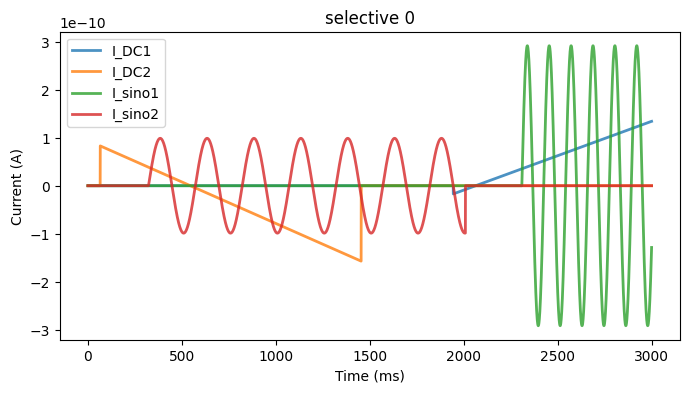

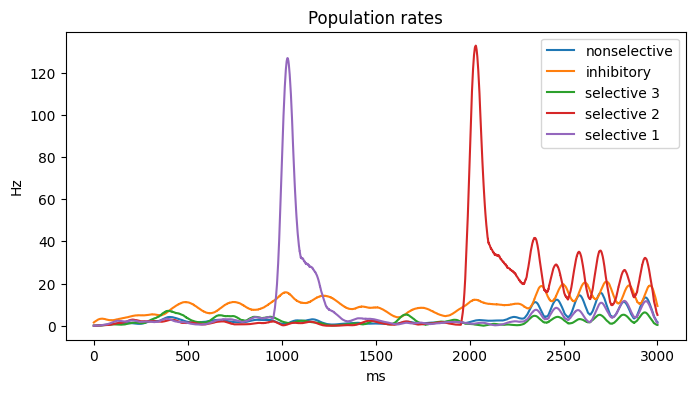

Value to maximize: -17.45705836185713
DC_amp1: -0.2668, DC_amp_slope1: -0.072, DC_start_time1: 418.4541, DC_duration1: 384.9784
DC_amp2: 0.2307, DC_amp_slope2: 0.1457, DC_start_time2: 2762.4817, DC_duration2: 2262.2041
sino_amp1: 0.0721, sino_freq1: 1.3409, sino_start_time1: 1029.3599, sino_duration1: 1318.6211
sino_amp2: 0.2712, sino_freq2: 5.2933, sino_start_time2: 2550.2168, sino_duration2: 752.5768
Pop1 mean_fr in the window [2200, 3000] ms: 1.1321682238871944
Pop2 mean_fr in the window [2200, 3000] ms: 5.836776184421489
Difference in mean_fr: -4.704607960534295


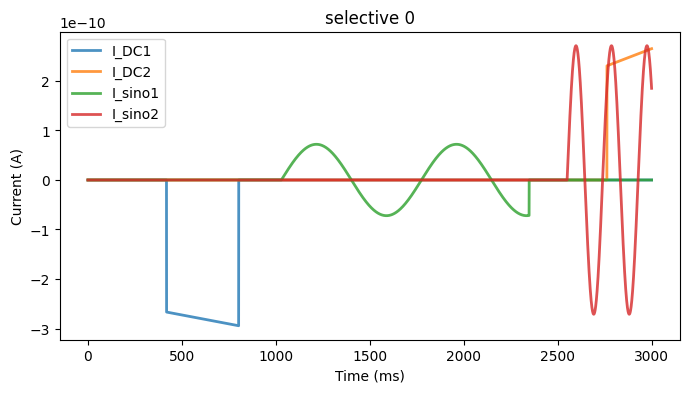

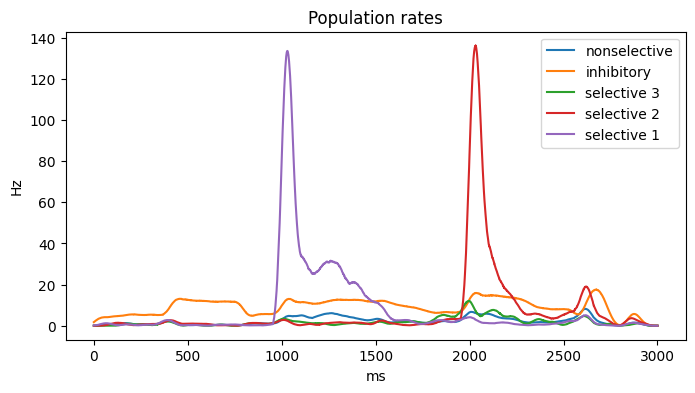

Value to maximize: -4.704607960534295


In [ ]:
acq_name = 'LogEI'
train_x, train_y = ibnn_utils.generate_initial_data(objective_func_tensor, stim_bounds, n=2)


## run

### model

In [9]:
INPUT_DIMS = len(space)
N_INIT = 2 if not SMOKE_TEST else 2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.double
tkwargs = {"device": device, "dtype": dtype}

from functools import partial
# define kernels
ibnn_kernel = InfiniteWidthBNNKernel(2, device=device)
ibnn_kernel.weight_var = 10.0
ibnn_kernel.bias_var = 5.0
ibnn_kernel = ScaleKernel(ibnn_kernel, device=device)

# run BO loop
acqf_classes = {"LogEI": LogExpectedImprovement}
results = {}

In [ ]:
init_x_stored = train_x
init_y_stored = train_y

### loop

In [ ]:
updated_x = init_x_stored
updated_y = init_y_stored

In [ ]:
N_ITERATIONS = 1500
for acq_name, acqf_class in acqf_classes.items():
    run_bo_with_acqf = partial(ibnn_utils.gp_bo_loop, f=objective_func_tensor, bounds=stim_bounds, acqf_class=acqf_class, 
                               init_x=updated_x, 
                               init_y=updated_y, 
                               n_iterations=N_ITERATIONS)
    ibnn_x, ibnn_y = run_bo_with_acqf(kernel=ibnn_kernel, optimize_hypers=False)
    # matern_x, matern_y = run_bo_with_acqf(kernel=matern_kernel, optimize_hypers=True)
    # rbf_x, rbf_y = run_bo_with_acqf(kernel=rbf_kernel, optimize_hypers=True)
    results[acq_name] = {
        "BNN": (ibnn_x, ibnn_y),
        # "Matern": (matern_x, matern_y),
        # "RBF": (rbf_x, rbf_y),
    }

    acq_name = 'LogEI'
# updated_x = torch.cat([updated_x, results[acq_name]['BNN'][0]], dim=0)
# updated_y = torch.cat([updated_y, results[acq_name]['BNN'][1]], dim=0)
# # After your BO loop finishes
# torch.save(updated_x, "updated_x.pt")

In [ ]:
pls_stop

In [ ]:
# updated_x = torch.cat([updated_x, results[acq_name]['BNN'][0]], dim=0)
# updated_y = torch.cat([updated_y, results[acq_name]['BNN'][1]], dim=0)

### load updated_x and y

In [10]:
most_recent_folder = ibnn_utils.get_most_recent_result_subfolder_name(results_dir='stored_results', prefix = 'run_')
updated_x = torch.load(os.path.join(most_recent_folder, "updated_x.pt"))
updated_y = torch.load(os.path.join(most_recent_folder, "updated_y.pt"))

In [11]:
updated_x.shape

torch.Size([1107, 16])

# plot results

In [ ]:
# import matplotlib
# def plot_cum_max(y, **kwargs):
#     cum_max = (torch.cummax(y, dim=0)[0]).cpu()
#     plt.plot(range(len(cum_max)), cum_max, **kwargs)

# plt.figure(figsize=(8, 6))

# colors = matplotlib.cm.get_cmap("tab10").colors
# plot_cum_max(-updated_y, label=f"I-BNN ({acq_name})", color=colors[0], ls='-')
# plt.xlabel("BO Iterations")
# plt.ylabel("Max Value")
# plt.legend()
# plt.show()

# plot currents of best results

Top 1 parameters: tensor([  3000.0000,   3000.0000,      0.0000,      0.2000,   3000.0000,
          3000.0000,      0.0000,     -0.2000,      0.0000,   3000.0000,
             0.3000,      0.0100,   3000.0000,     20.0000,      0.0000,
            10.0000], dtype=torch.float64)
Top 1 values: tensor([10.5401], dtype=torch.float64)
DC_amp1: 0.0, DC_amp_slope1: 0.2, DC_start_time1: 3000.0, DC_duration1: 3000.0
DC_amp2: 0.0, DC_amp_slope2: -0.2, DC_start_time2: 3000.0, DC_duration2: 3000.0
sino_amp1: 0.3, sino_freq1: 0.01, sino_start_time1: 0.0, sino_duration1: 3000.0
sino_amp2: 0.0, sino_freq2: 10.0, sino_start_time2: 3000.0, sino_duration2: 20.0
Pop1 mean_fr in the window [2200, 3000] ms: 3.4676941855204446
Pop2 mean_fr in the window [2200, 3000] ms: 20.758634778475596
Difference in mean_fr: -17.290940592955153


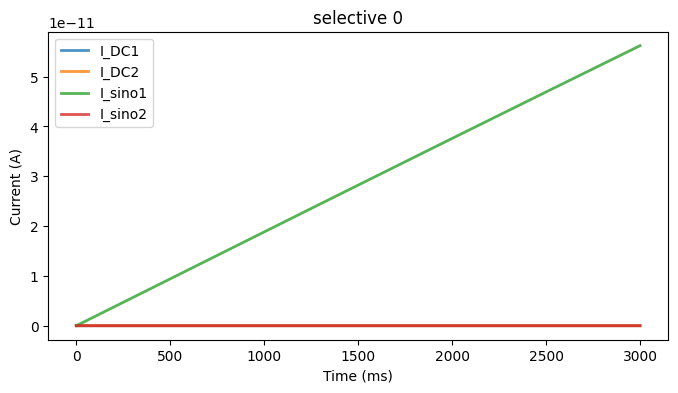

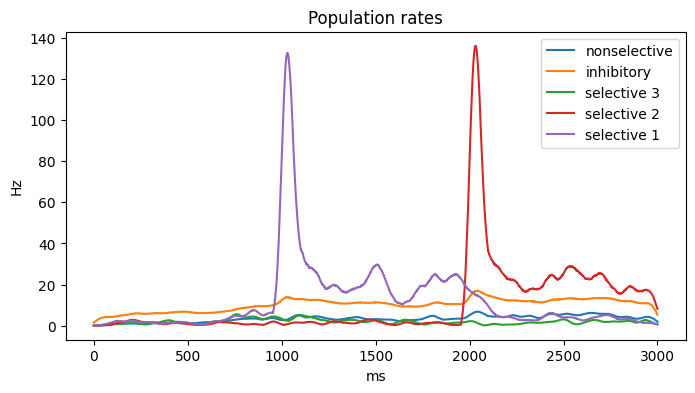

Value to maximize: -17.290940592955153
Top 2 parameters: tensor([  2156.5593,   3000.0000,      0.0000,      0.2000,   3000.0000,
          3000.0000,      0.3000,     -0.2000,   2109.5339,   3000.0000,
             0.3000,     10.0000,      0.0000,   3000.0000,      0.3000,
             0.0100], dtype=torch.float64)
Top 2 values: tensor([6.3480], dtype=torch.float64)
DC_amp1: 0.0, DC_amp_slope1: 0.2, DC_start_time1: 2156.5593, DC_duration1: 3000.0
DC_amp2: 0.3, DC_amp_slope2: -0.2, DC_start_time2: 3000.0, DC_duration2: 3000.0
sino_amp1: 0.3, sino_freq1: 10.0, sino_start_time1: 2109.5339, sino_duration1: 3000.0
sino_amp2: 0.3, sino_freq2: 0.01, sino_start_time2: 0.0, sino_duration2: 3000.0
Pop1 mean_fr in the window [2200, 3000] ms: 15.875633393785275
Pop2 mean_fr in the window [2200, 3000] ms: 15.630783302288217
Difference in mean_fr: 0.2448500914970584


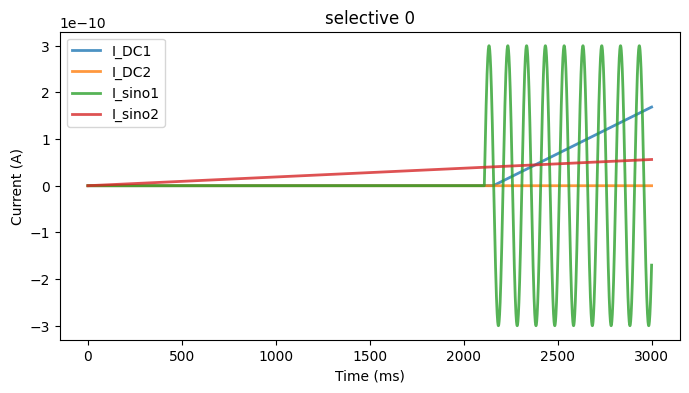

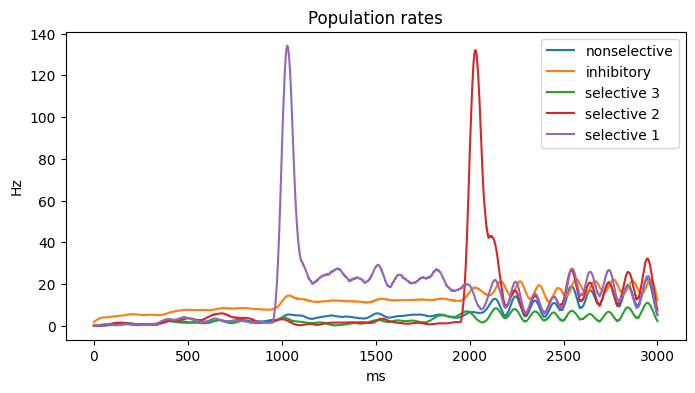

Value to maximize: 0.2448500914970584
Top 3 parameters: tensor([     0.0000,     20.0000,      0.0000,     -0.2000,   1460.6050,
          3000.0000,      0.3000,     -0.2000,   1372.5138,   3000.0000,
             0.3000,      0.0100,   3000.0000,   1346.7225,      0.0000,
             0.0100], dtype=torch.float64)
Top 3 values: tensor([5.5883], dtype=torch.float64)
DC_amp1: 0.0, DC_amp_slope1: -0.2, DC_start_time1: 0.0, DC_duration1: 20.0
DC_amp2: 0.3, DC_amp_slope2: -0.2, DC_start_time2: 1460.605, DC_duration2: 3000.0
sino_amp1: 0.3, sino_freq1: 0.01, sino_start_time1: 1372.5138, sino_duration1: 3000.0
sino_amp2: 0.0, sino_freq2: 0.01, sino_start_time2: 3000.0, sino_duration2: 1346.7225
Pop1 mean_fr in the window [2200, 3000] ms: 7.2467325120552
Pop2 mean_fr in the window [2200, 3000] ms: 17.47955808451701
Difference in mean_fr: -10.23282557246181


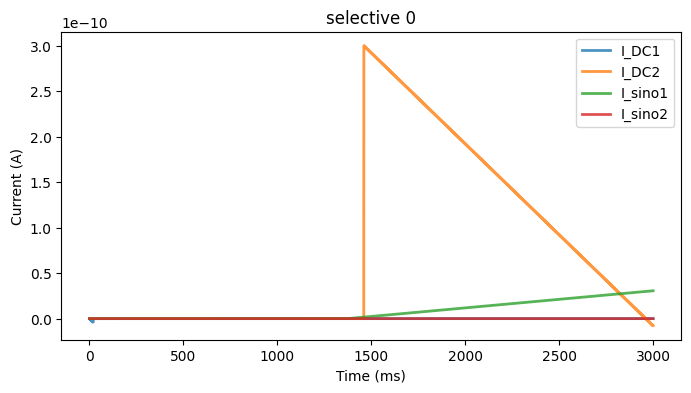

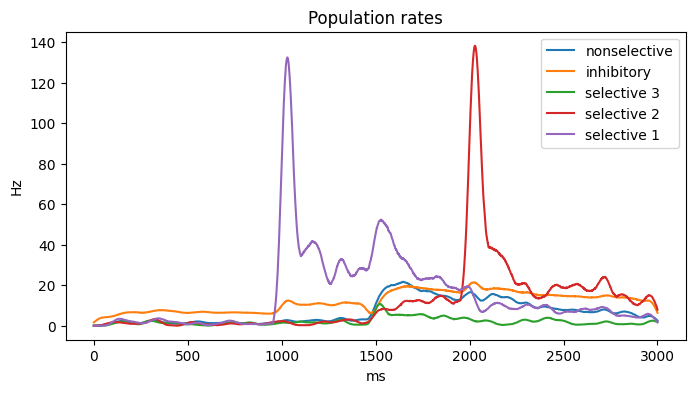

Value to maximize: -10.23282557246181
Top 4 parameters: tensor([     0.0000,   1472.2034,     -0.3000,      0.2000,   1384.9283,
            20.0000,      0.3000,     -0.2000,   3000.0000,   1063.1418,
             0.3000,     10.0000,      0.0000,   3000.0000,      0.3000,
             0.0100], dtype=torch.float64)
Top 4 values: tensor([5.3446], dtype=torch.float64)
DC_amp1: -0.3, DC_amp_slope1: 0.2, DC_start_time1: 0.0, DC_duration1: 1472.2034
DC_amp2: 0.3, DC_amp_slope2: -0.2, DC_start_time2: 1384.9283, DC_duration2: 20.0
sino_amp1: 0.3, sino_freq1: 10.0, sino_start_time1: 3000.0, sino_duration1: 1063.1418
sino_amp2: 0.3, sino_freq2: 0.01, sino_start_time2: 0.0, sino_duration2: 3000.0
Pop1 mean_fr in the window [2200, 3000] ms: 8.99302571481939
Pop2 mean_fr in the window [2200, 3000] ms: 8.476401154820982
Difference in mean_fr: 0.5166245599984087


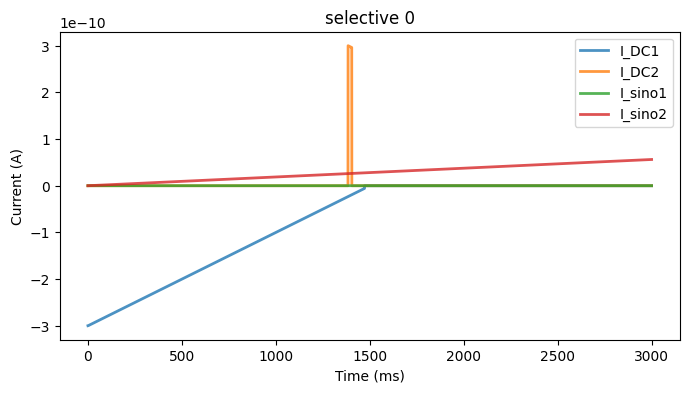

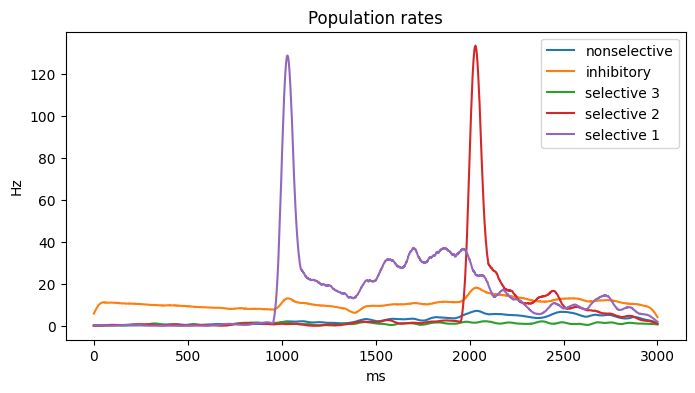

Value to maximize: 0.5166245599984087
Top 5 parameters: tensor([     0.0000,     20.0000,     -0.3000,      0.2000,      0.0000,
          3000.0000,      0.0000,      0.2000,      0.0000,     20.0000,
             0.0000,     10.0000,   3000.0000,     20.0000,      0.0000,
             0.0100], dtype=torch.float64)
Top 5 values: tensor([4.6026], dtype=torch.float64)
DC_amp1: -0.3, DC_amp_slope1: 0.2, DC_start_time1: 0.0, DC_duration1: 20.0
DC_amp2: 0.0, DC_amp_slope2: 0.2, DC_start_time2: 0.0, DC_duration2: 3000.0
sino_amp1: 0.0, sino_freq1: 10.0, sino_start_time1: 0.0, sino_duration1: 20.0
sino_amp2: 0.0, sino_freq2: 0.01, sino_start_time2: 3000.0, sino_duration2: 20.0
Pop1 mean_fr in the window [2200, 3000] ms: 38.37538445725014
Pop2 mean_fr in the window [2200, 3000] ms: 37.747035227856486
Difference in mean_fr: 0.6283492293936561


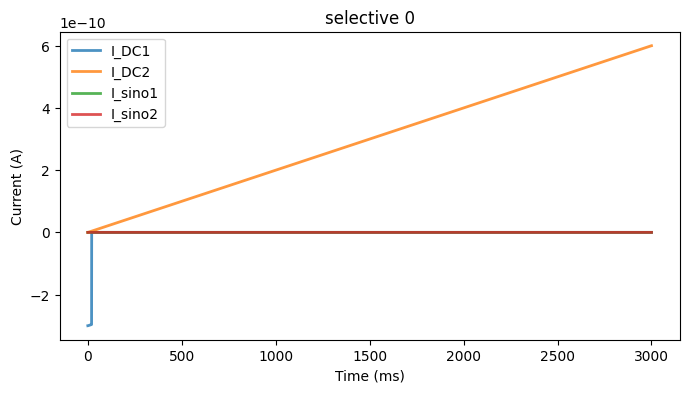

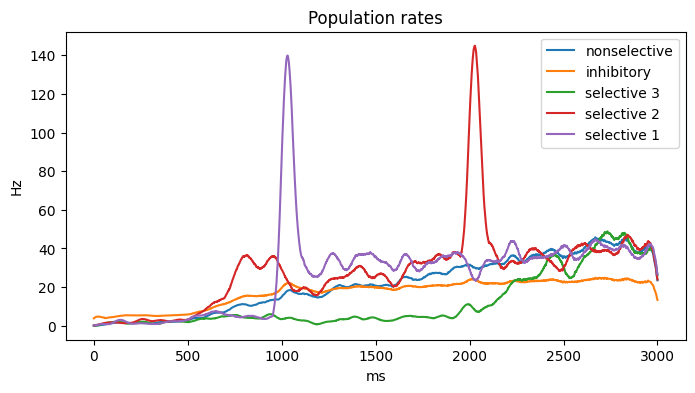

Value to maximize: 0.6283492293936561
Top 6 parameters: tensor([     0.0000,     20.0000,      0.0000,     -0.2000,      0.0000,
          3000.0000,      0.0000,      0.2000,   3000.0000,     20.0000,
             0.0000,     10.0000,      0.0000,     20.0000,      0.0000,
            10.0000], dtype=torch.float64)
Top 6 values: tensor([4.3068], dtype=torch.float64)
DC_amp1: 0.0, DC_amp_slope1: -0.2, DC_start_time1: 0.0, DC_duration1: 20.0
DC_amp2: 0.0, DC_amp_slope2: 0.2, DC_start_time2: 0.0, DC_duration2: 3000.0
sino_amp1: 0.0, sino_freq1: 10.0, sino_start_time1: 3000.0, sino_duration1: 20.0
sino_amp2: 0.0, sino_freq2: 10.0, sino_start_time2: 0.0, sino_duration2: 20.0
Pop1 mean_fr in the window [2200, 3000] ms: 34.781481886883945
Pop2 mean_fr in the window [2200, 3000] ms: 38.143990603854064
Difference in mean_fr: -3.362508716970119


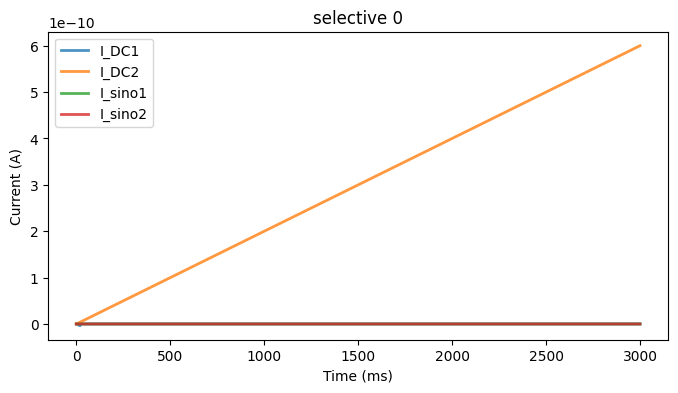

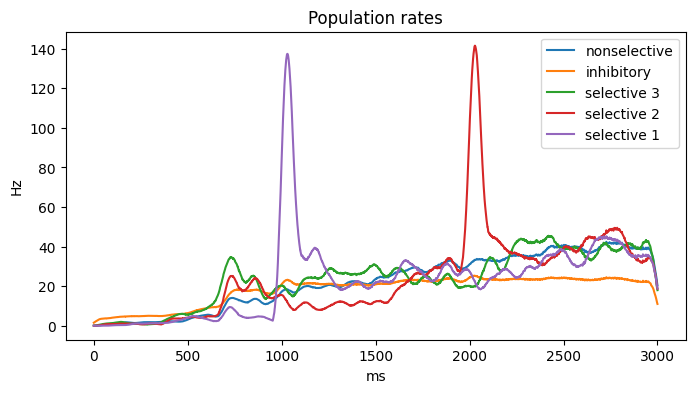

Value to maximize: -3.362508716970119
Top 7 parameters: tensor([  3000.0000,   3000.0000,      0.0000,     -0.2000,   1479.8136,
          1002.2513,      0.0000,      0.2000,   1488.0675,     20.0000,
             0.0000,      0.0100,      0.0000,   3000.0000,      0.0000,
             0.0100], dtype=torch.float64)
Top 7 values: tensor([4.2624], dtype=torch.float64)
DC_amp1: 0.0, DC_amp_slope1: -0.2, DC_start_time1: 3000.0, DC_duration1: 3000.0
DC_amp2: 0.0, DC_amp_slope2: 0.2, DC_start_time2: 1479.8136, DC_duration2: 1002.2513
sino_amp1: 0.0, sino_freq1: 0.01, sino_start_time1: 1488.0675, sino_duration1: 20.0
sino_amp2: 0.0, sino_freq2: 0.01, sino_start_time2: 0.0, sino_duration2: 3000.0
Pop1 mean_fr in the window [2200, 3000] ms: 10.859735004913949
Pop2 mean_fr in the window [2200, 3000] ms: 10.806054678830245
Difference in mean_fr: 0.05368032608370399


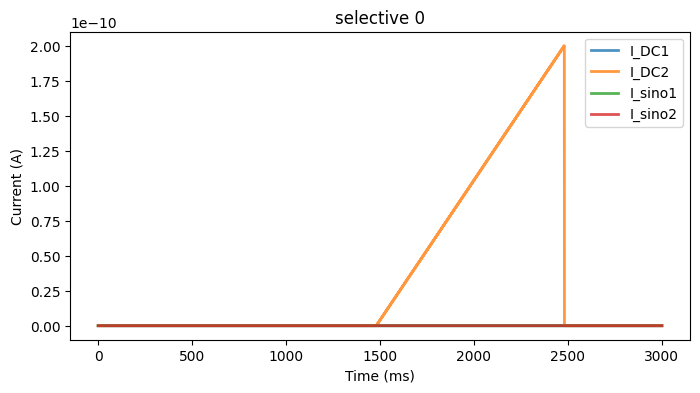

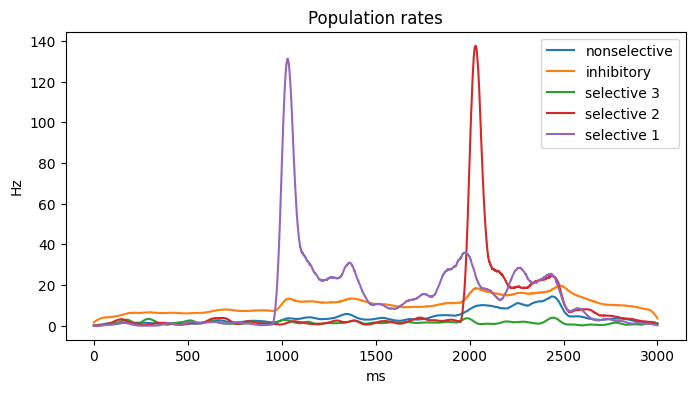

Value to maximize: 0.05368032608370399
Top 8 parameters: tensor([ 3000.0000,    20.0000,     0.0000,     0.2000,     0.0000,  3000.0000,
            0.0000,     0.2000,     0.0000,    20.0000,     0.0000,    10.0000,
         3000.0000,  3000.0000,     0.3000,    10.0000], dtype=torch.float64)
Top 8 values: tensor([4.0903], dtype=torch.float64)
DC_amp1: 0.0, DC_amp_slope1: 0.2, DC_start_time1: 3000.0, DC_duration1: 20.0
DC_amp2: 0.0, DC_amp_slope2: 0.2, DC_start_time2: 0.0, DC_duration2: 3000.0
sino_amp1: 0.0, sino_freq1: 10.0, sino_start_time1: 0.0, sino_duration1: 20.0
sino_amp2: 0.3, sino_freq2: 10.0, sino_start_time2: 3000.0, sino_duration2: 3000.0
Pop1 mean_fr in the window [2200, 3000] ms: 35.90806705475293
Pop2 mean_fr in the window [2200, 3000] ms: 36.54239964563291
Difference in mean_fr: -0.6343325908799855


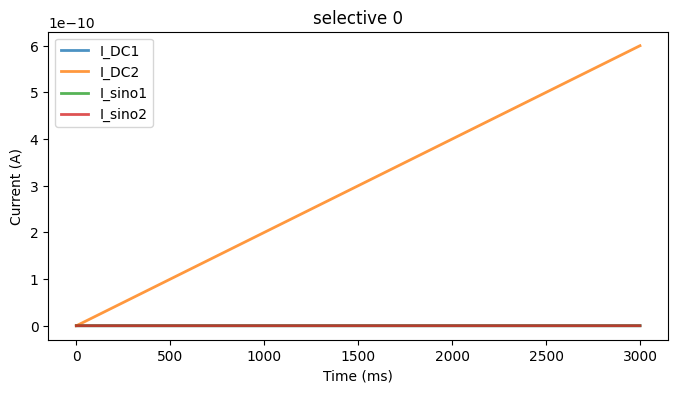

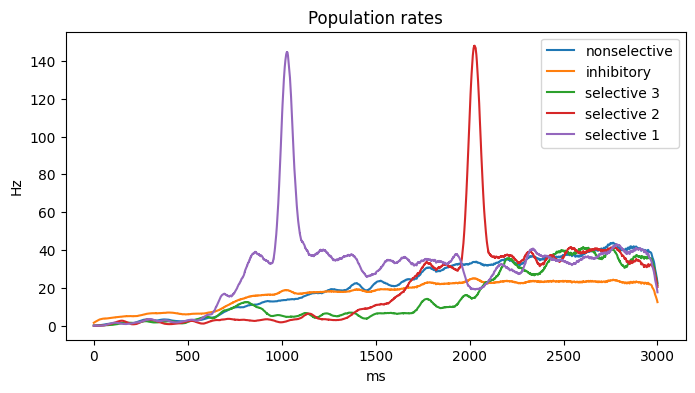

Value to maximize: -0.6343325908799855
Top 9 parameters: tensor([  3000.0000,     20.0000,     -0.3000,     -0.2000,   1195.3055,
          1183.5975,      0.3000,      0.2000,   3000.0000,   1177.7655,
             0.3000,     10.0000,      0.0000,   3000.0000,      0.3000,
             0.0100], dtype=torch.float64)
Top 9 values: tensor([3.9390], dtype=torch.float64)
DC_amp1: -0.3, DC_amp_slope1: -0.2, DC_start_time1: 3000.0, DC_duration1: 20.0
DC_amp2: 0.3, DC_amp_slope2: 0.2, DC_start_time2: 1195.3055, DC_duration2: 1183.5975
sino_amp1: 0.3, sino_freq1: 10.0, sino_start_time1: 3000.0, sino_duration1: 1177.7655
sino_amp2: 0.3, sino_freq2: 0.01, sino_start_time2: 0.0, sino_duration2: 3000.0
Pop1 mean_fr in the window [2200, 3000] ms: 12.409291235697054
Pop2 mean_fr in the window [2200, 3000] ms: 12.883765816163324
Difference in mean_fr: -0.47447458046626956


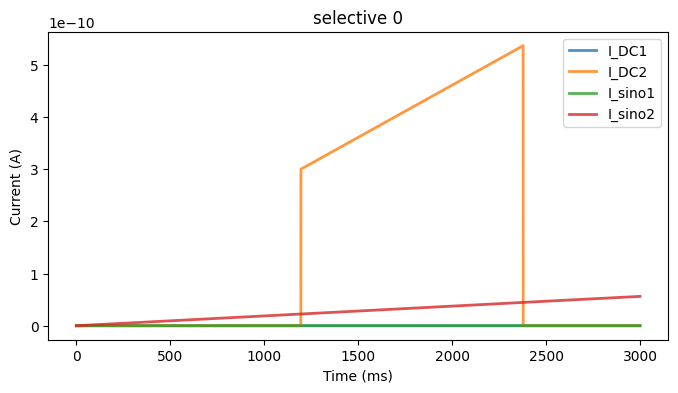

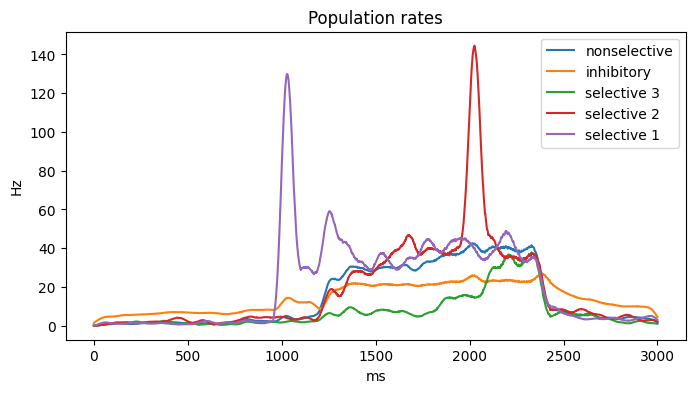

Value to maximize: -0.47447458046626956
Top 10 parameters: tensor([     0.0000,   3000.0000,     -0.3000,      0.2000,      0.0000,
            20.0000,      0.3000,      0.2000,      0.0000,     20.0000,
             0.3000,     10.0000,   3000.0000,     20.0000,      0.0000,
            10.0000], dtype=torch.float64)
Top 10 values: tensor([3.8311], dtype=torch.float64)
DC_amp1: -0.3, DC_amp_slope1: 0.2, DC_start_time1: 0.0, DC_duration1: 3000.0
DC_amp2: 0.3, DC_amp_slope2: 0.2, DC_start_time2: 0.0, DC_duration2: 20.0
sino_amp1: 0.3, sino_freq1: 10.0, sino_start_time1: 0.0, sino_duration1: 20.0
sino_amp2: 0.0, sino_freq2: 10.0, sino_start_time2: 3000.0, sino_duration2: 20.0
Pop1 mean_fr in the window [2200, 3000] ms: 14.99893982692583
Pop2 mean_fr in the window [2200, 3000] ms: 30.693961998523665
Difference in mean_fr: -15.695022171597836


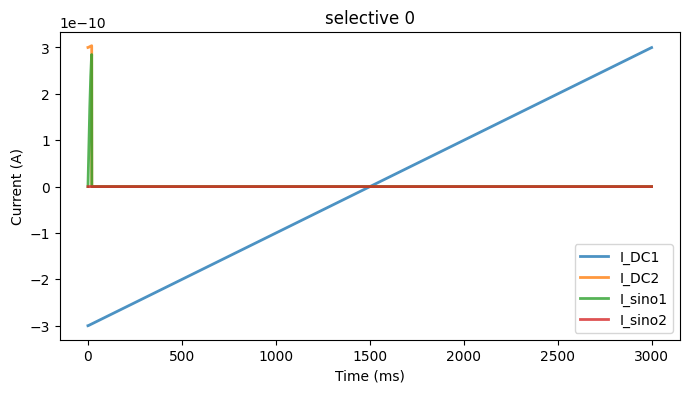

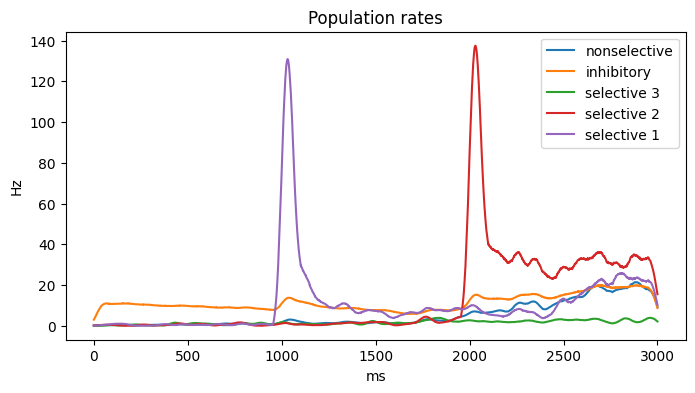

Value to maximize: -15.695022171597836
Top 11 parameters: tensor([  1043.6543,   3000.0000,      0.0000,      0.2000,   3000.0000,
          1107.2676,      0.3000,     -0.2000,      0.0000,   1047.4081,
             0.0000,     10.0000,    972.8243,   1133.6587,      0.3000,
             0.0100], dtype=torch.float64)
Top 11 values: tensor([3.8279], dtype=torch.float64)
DC_amp1: 0.0, DC_amp_slope1: 0.2, DC_start_time1: 1043.6543, DC_duration1: 3000.0
DC_amp2: 0.3, DC_amp_slope2: -0.2, DC_start_time2: 3000.0, DC_duration2: 1107.2676
sino_amp1: 0.0, sino_freq1: 10.0, sino_start_time1: 0.0, sino_duration1: 1047.4081
sino_amp2: 0.3, sino_freq2: 0.01, sino_start_time2: 972.8243, sino_duration2: 1133.6587
Pop1 mean_fr in the window [2200, 3000] ms: 26.746058825617048
Pop2 mean_fr in the window [2200, 3000] ms: 31.73705134938683
Difference in mean_fr: -4.990992523769783


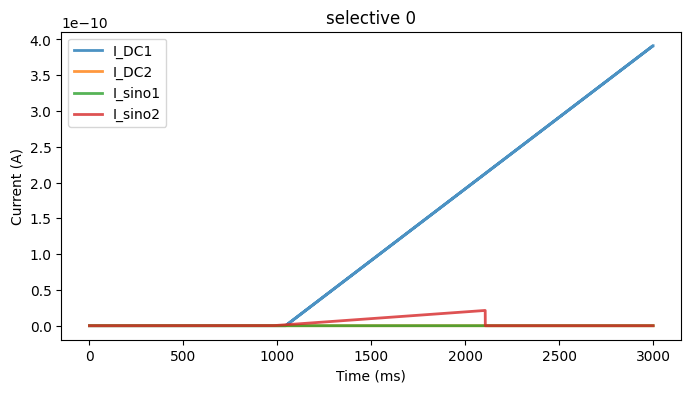

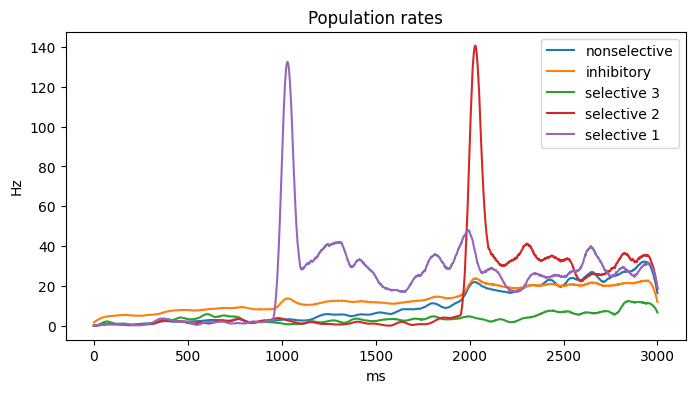

Value to maximize: -4.990992523769783
Top 12 parameters: tensor([     0.0000,     20.0000,      0.0000,      0.2000,   1003.5516,
          1184.7069,      0.3000,     -0.2000,      0.0000,   3000.0000,
             0.3000,      0.0100,      0.0000,   1120.9399,      0.0000,
             0.0100], dtype=torch.float64)
Top 12 values: tensor([3.6294], dtype=torch.float64)
DC_amp1: 0.0, DC_amp_slope1: 0.2, DC_start_time1: 0.0, DC_duration1: 20.0
DC_amp2: 0.3, DC_amp_slope2: -0.2, DC_start_time2: 1003.5516, DC_duration2: 1184.7069
sino_amp1: 0.3, sino_freq1: 0.01, sino_start_time1: 0.0, sino_duration1: 3000.0
sino_amp2: 0.0, sino_freq2: 0.01, sino_start_time2: 0.0, sino_duration2: 1120.9399
Pop1 mean_fr in the window [2200, 3000] ms: 4.843190507446318
Pop2 mean_fr in the window [2200, 3000] ms: 9.581034156675571
Difference in mean_fr: -4.737843649229253


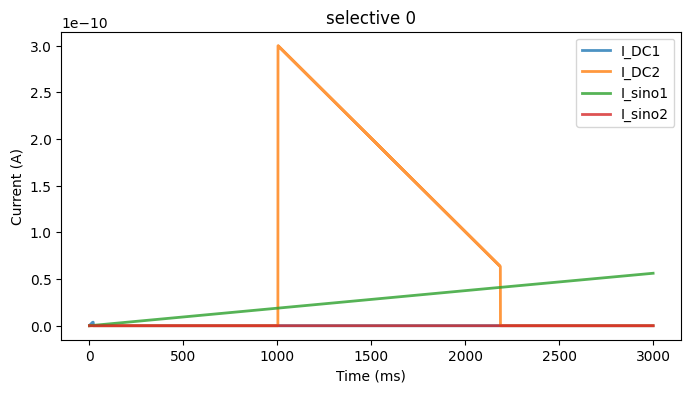

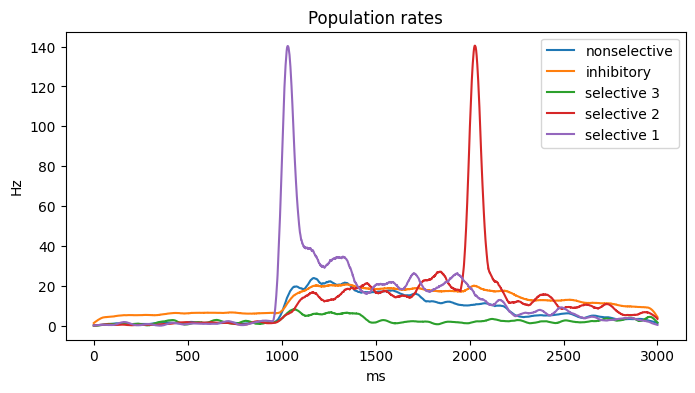

Value to maximize: -4.737843649229253
Top 13 parameters: tensor([     0.0000,   3000.0000,     -0.3000,      0.2000,   1393.1282,
          1168.3936,      0.3000,      0.2000,   3000.0000,     20.0000,
             0.0000,     10.0000,   3000.0000,   1566.0027,      0.3000,
             0.0100], dtype=torch.float64)
Top 13 values: tensor([3.5904], dtype=torch.float64)
DC_amp1: -0.3, DC_amp_slope1: 0.2, DC_start_time1: 0.0, DC_duration1: 3000.0
DC_amp2: 0.3, DC_amp_slope2: 0.2, DC_start_time2: 1393.1282, DC_duration2: 1168.3936
sino_amp1: 0.0, sino_freq1: 10.0, sino_start_time1: 3000.0, sino_duration1: 20.0
sino_amp2: 0.3, sino_freq2: 0.01, sino_start_time2: 3000.0, sino_duration2: 1566.0027
Pop1 mean_fr in the window [2200, 3000] ms: 0.022324219098815903
Pop2 mean_fr in the window [2200, 3000] ms: 0.0
Difference in mean_fr: 0.022324219098815903


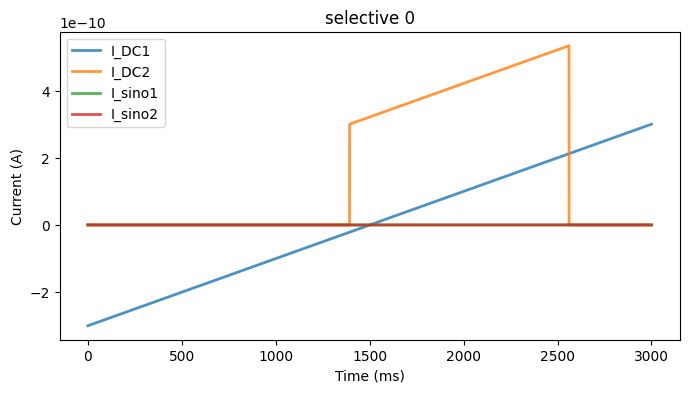

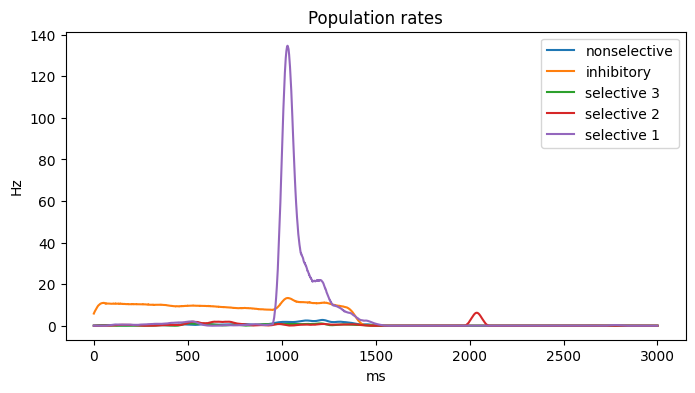

Value to maximize: 0.022324219098815903
Top 14 parameters: tensor([  1216.8535,     20.0000,      0.0000,      0.2000,      0.0000,
            20.0000,      0.3000,     -0.2000,   1274.4156,   3000.0000,
             0.0000,      0.0100,      0.0000,   3000.0000,      0.3000,
             0.0100], dtype=torch.float64)
Top 14 values: tensor([2.8569], dtype=torch.float64)
DC_amp1: 0.0, DC_amp_slope1: 0.2, DC_start_time1: 1216.8535, DC_duration1: 20.0
DC_amp2: 0.3, DC_amp_slope2: -0.2, DC_start_time2: 0.0, DC_duration2: 20.0
sino_amp1: 0.0, sino_freq1: 0.01, sino_start_time1: 1274.4156, sino_duration1: 3000.0
sino_amp2: 0.3, sino_freq2: 0.01, sino_start_time2: 0.0, sino_duration2: 3000.0
Pop1 mean_fr in the window [2200, 3000] ms: 4.793701085007007
Pop2 mean_fr in the window [2200, 3000] ms: 18.586511184341006
Difference in mean_fr: -13.792810099333998


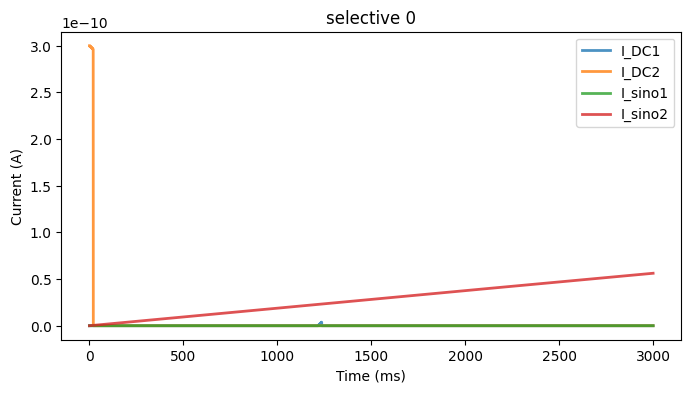

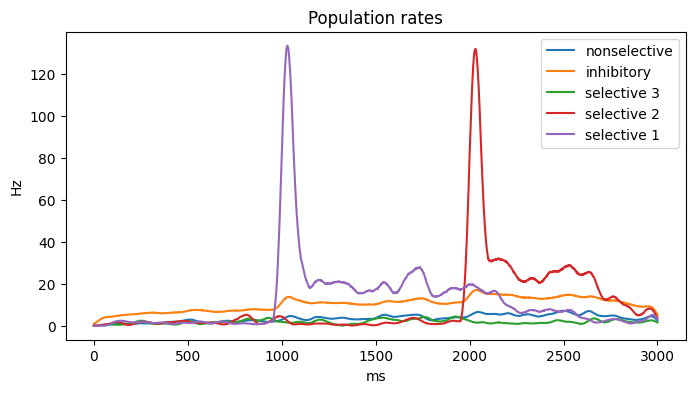

Value to maximize: -13.792810099333998
Top 15 parameters: tensor([  3000.0000,   3000.0000,     -0.3000,     -0.2000,      0.0000,
          3000.0000,      0.0000,      0.2000,      0.0000,     20.0000,
             0.3000,     10.0000,      0.0000,     20.0000,      0.3000,
             0.0100], dtype=torch.float64)
Top 15 values: tensor([2.5095], dtype=torch.float64)
DC_amp1: -0.3, DC_amp_slope1: -0.2, DC_start_time1: 3000.0, DC_duration1: 3000.0
DC_amp2: 0.0, DC_amp_slope2: 0.2, DC_start_time2: 0.0, DC_duration2: 3000.0
sino_amp1: 0.3, sino_freq1: 10.0, sino_start_time1: 0.0, sino_duration1: 20.0
sino_amp2: 0.3, sino_freq2: 0.01, sino_start_time2: 0.0, sino_duration2: 20.0
Pop1 mean_fr in the window [2200, 3000] ms: 36.429384576370396
Pop2 mean_fr in the window [2200, 3000] ms: 37.912854511465376
Difference in mean_fr: -1.4834699350949805


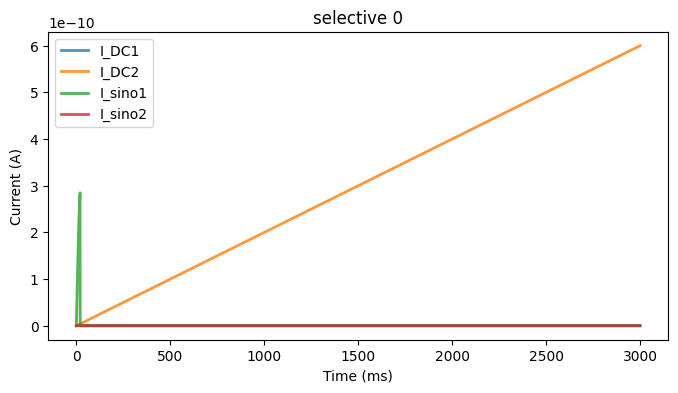

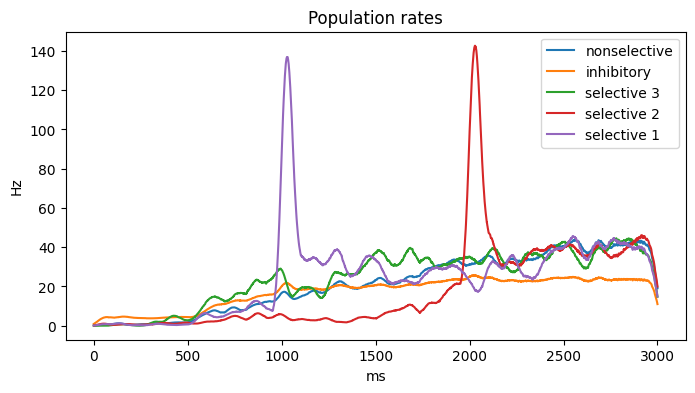

Value to maximize: -1.4834699350949805
Top 16 parameters: tensor([  1486.7968,   3000.0000,      0.0000,     -0.2000,      0.0000,
          3000.0000,      0.0000,      0.2000,    871.4012,   3000.0000,
             0.0000,     10.0000,   1399.2028,     20.0000,      0.0000,
             0.0100], dtype=torch.float64)
Top 16 values: tensor([2.4749], dtype=torch.float64)
DC_amp1: 0.0, DC_amp_slope1: -0.2, DC_start_time1: 1486.7968, DC_duration1: 3000.0
DC_amp2: 0.0, DC_amp_slope2: 0.2, DC_start_time2: 0.0, DC_duration2: 3000.0
sino_amp1: 0.0, sino_freq1: 10.0, sino_start_time1: 871.4012, sino_duration1: 3000.0
sino_amp2: 0.0, sino_freq2: 0.01, sino_start_time2: 1399.2028, sino_duration2: 20.0
Pop1 mean_fr in the window [2200, 3000] ms: 15.937394317113432
Pop2 mean_fr in the window [2200, 3000] ms: 22.68318619998337
Difference in mean_fr: -6.7457918828699395


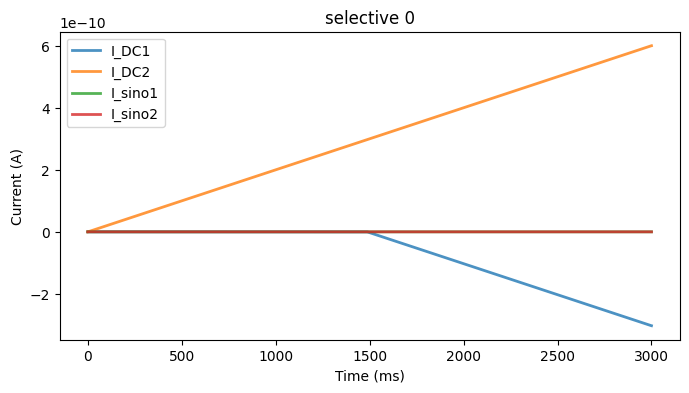

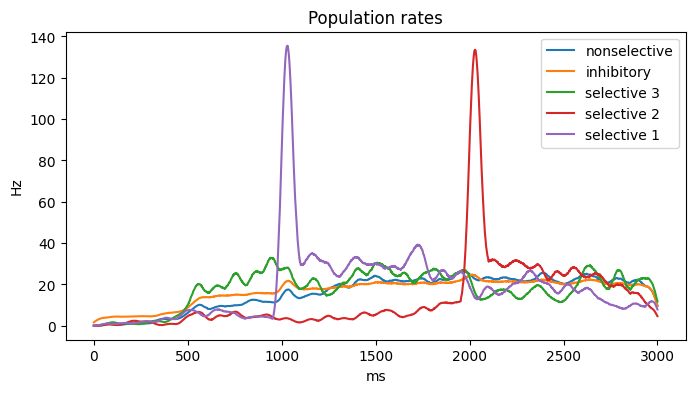

Value to maximize: -6.7457918828699395
Top 17 parameters: tensor([  3000.0000,   3000.0000,      0.0000,     -0.2000,   1363.8372,
          3000.0000,      0.3000,      0.2000,      0.0000,     20.0000,
             0.3000,      0.0100,   2202.8545,   1336.5886,      0.3000,
            10.0000], dtype=torch.float64)
Top 17 values: tensor([2.3109], dtype=torch.float64)
DC_amp1: 0.0, DC_amp_slope1: -0.2, DC_start_time1: 3000.0, DC_duration1: 3000.0
DC_amp2: 0.3, DC_amp_slope2: 0.2, DC_start_time2: 1363.8372, DC_duration2: 3000.0
sino_amp1: 0.3, sino_freq1: 0.01, sino_start_time1: 0.0, sino_duration1: 20.0
sino_amp2: 0.3, sino_freq2: 10.0, sino_start_time2: 2202.8545, sino_duration2: 1336.5886
Pop1 mean_fr in the window [2200, 3000] ms: 30.586690936061743
Pop2 mean_fr in the window [2200, 3000] ms: 31.272993867369895
Difference in mean_fr: -0.6863029313081519


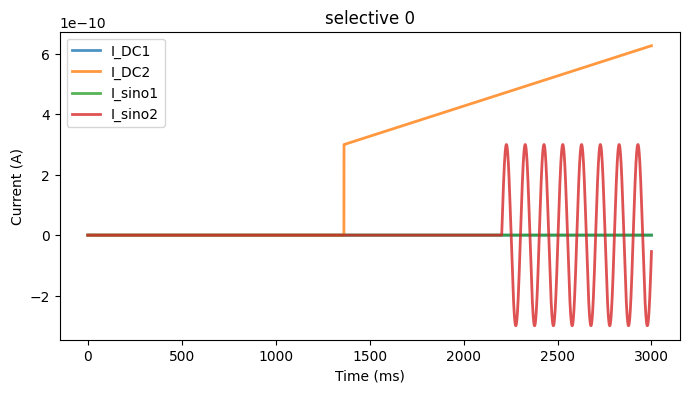

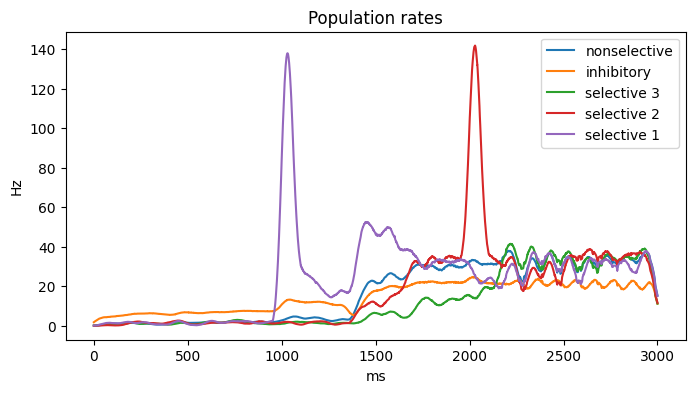

Value to maximize: -0.6863029313081519
Top 18 parameters: tensor([  1105.9308,    999.5648,      0.0000,     -0.2000,   1398.1288,
          1699.4404,      0.3000,      0.2000,   3000.0000,     20.0000,
             0.3000,      0.0100,   3000.0000,   3000.0000,      0.3000,
            10.0000], dtype=torch.float64)
Top 18 values: tensor([2.1048], dtype=torch.float64)
DC_amp1: 0.0, DC_amp_slope1: -0.2, DC_start_time1: 1105.9308, DC_duration1: 999.5648
DC_amp2: 0.3, DC_amp_slope2: 0.2, DC_start_time2: 1398.1288, DC_duration2: 1699.4404
sino_amp1: 0.3, sino_freq1: 0.01, sino_start_time1: 3000.0, sino_duration1: 20.0
sino_amp2: 0.3, sino_freq2: 10.0, sino_start_time2: 3000.0, sino_duration2: 3000.0
Pop1 mean_fr in the window [2200, 3000] ms: 40.057621658515345
Pop2 mean_fr in the window [2200, 3000] ms: 35.760629886627925
Difference in mean_fr: 4.29699177188742


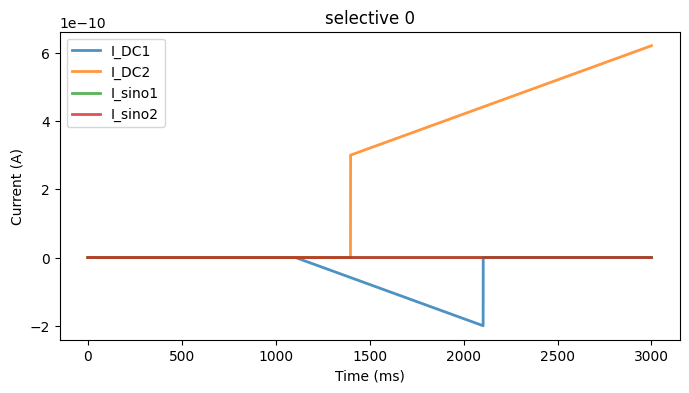

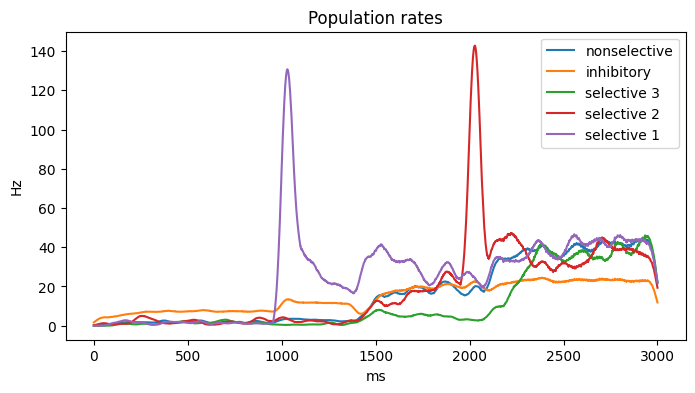

Value to maximize: 4.29699177188742
Top 19 parameters: tensor([     0.0000,   3000.0000,      0.0000,      0.2000,   1165.6591,
          1287.1689,      0.3000,     -0.2000,   3000.0000,   1355.5717,
             0.0000,     10.0000,   3000.0000,     20.0000,      0.0000,
             0.0100], dtype=torch.float64)
Top 19 values: tensor([2.0380], dtype=torch.float64)
DC_amp1: 0.0, DC_amp_slope1: 0.2, DC_start_time1: 0.0, DC_duration1: 3000.0
DC_amp2: 0.3, DC_amp_slope2: -0.2, DC_start_time2: 1165.6591, DC_duration2: 1287.1689
sino_amp1: 0.0, sino_freq1: 10.0, sino_start_time1: 3000.0, sino_duration1: 1355.5717
sino_amp2: 0.0, sino_freq2: 0.01, sino_start_time2: 3000.0, sino_duration2: 20.0
Pop1 mean_fr in the window [2200, 3000] ms: 38.53935727243881
Pop2 mean_fr in the window [2200, 3000] ms: 39.54200405189042
Difference in mean_fr: -1.0026467794516165


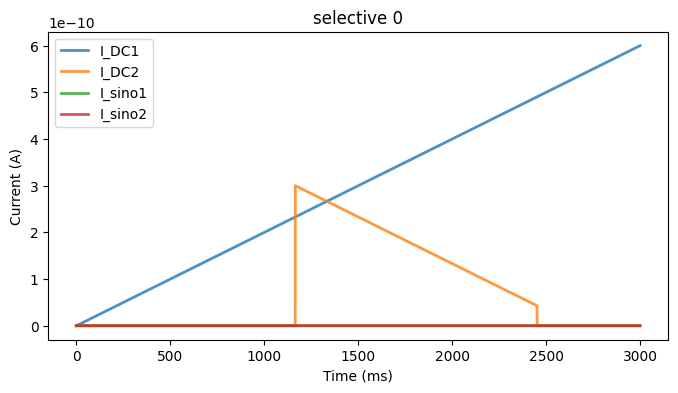

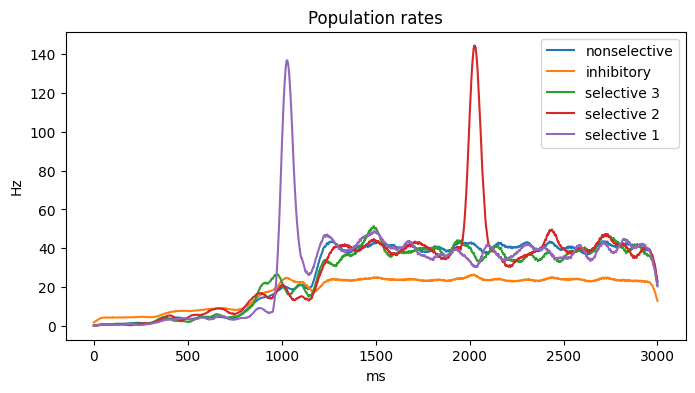

Value to maximize: -1.0026467794516165
Top 20 parameters: tensor([     0.0000,   3000.0000,      0.0000,      0.2000,   3000.0000,
          3000.0000,      0.0000,     -0.2000,      0.0000,   1319.0767,
             0.0000,      0.0100,      0.0000,   1328.5999,      0.3000,
            10.0000], dtype=torch.float64)
Top 20 values: tensor([2.0159], dtype=torch.float64)
DC_amp1: 0.0, DC_amp_slope1: 0.2, DC_start_time1: 0.0, DC_duration1: 3000.0
DC_amp2: 0.0, DC_amp_slope2: -0.2, DC_start_time2: 3000.0, DC_duration2: 3000.0
sino_amp1: 0.0, sino_freq1: 0.01, sino_start_time1: 0.0, sino_duration1: 1319.0767
sino_amp2: 0.3, sino_freq2: 10.0, sino_start_time2: 0.0, sino_duration2: 1328.5999
Pop1 mean_fr in the window [2200, 3000] ms: 0.0
Pop2 mean_fr in the window [2200, 3000] ms: 0.0
Difference in mean_fr: 0.0


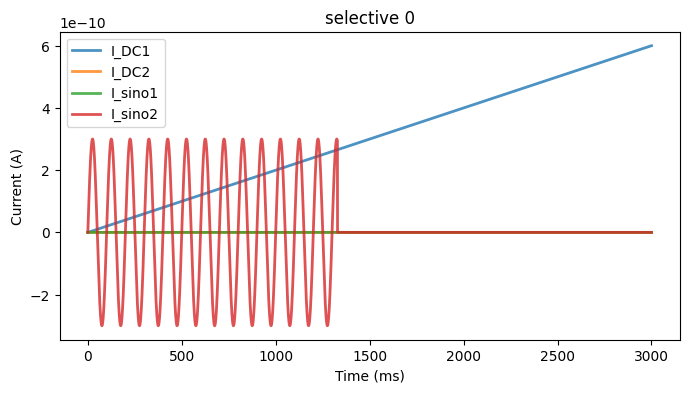

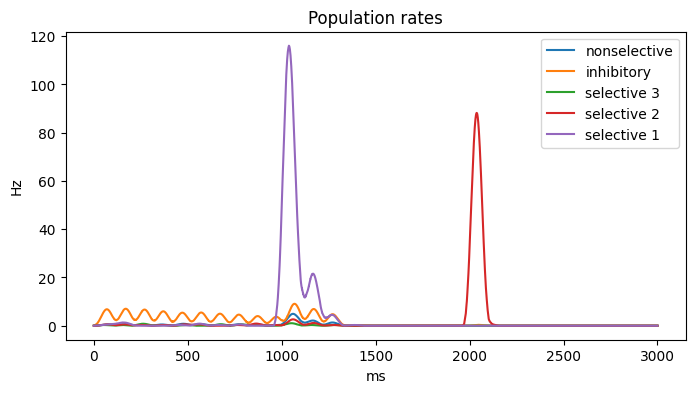

Value to maximize: 0.0


In [12]:
num_top_points = 20
# find the index of top k in updated_y
top_5_indices = torch.topk(updated_y.squeeze(), num_top_points).indices
# get the corresponding parameters
top_5_params = updated_x[top_5_indices]
# get the corresponding values
top_5_values = updated_y[top_5_indices]

for i in range(num_top_points):
    params = top_5_params[i]
    print(f"Top {i+1} parameters: {params}")
    print(f"Top {i+1} values: {top_5_values[i]}")
    # run the objective function with these parameters
    objective_func_tensor(params)